## Projet 10 : Détectez des faux billets avec R ou Python

### Contexte

>L'Organisation Nationale de lutte Contre le Faux-Monnayage (ONCFM) a pour objectif de mettre en place des méthodes d'identification des contrefaçons des billets en euros.

### Mission 

> Mettre en place un algorithme de détection automatique de faux billets en utilisant les dimensions géométriques fournies.

### Objectif
> Dans ce projet, nous allons **mettre en concurrence deux méthodes de prédiction** :
>- **Régression logistique classique** : un modèle linéaire utilisé pour la classification binaire.
>- **K-means** : un algorithme de clustering non supervisé. Nous utiliserons les centroïdes pour réaliser la prédiction.
> 
>L'objectif est de **choisir le modèle le plus performant** pour identifier un maximum de faux billets parmi la masse de billets analysés chaque jour.


## Sommaire


### Partie 1: Préparation, Nettoyage des Données et Analyse Exploratoire

### [1) Importation des données](#A1)
### [2) Nettoyage et préparation des données](#A2)

- [1.Table Billet](#A2.1)
 
### Partie 2: Modélisations statistiques

#### [1. Modélisation avec régression logistique](#B1)


#### [2. Modélisation avec k-means](#B2)

#### [3. Comparaison des performances des deux modèles (régression logistique et K-means)](#B3)

#### [4. Recommandations basées sur les résultats obtenus](#B4)


## Partie 1: Importation, nettoyage et préparation des données

### <a id="A1">1) Importation des données</a>

In [1]:
# Import des librairies et fonctions nécessaires aux analyses

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans

from mes_fonctions import backward, reg_lin, reg_log, predict_billets, reg_kmeans

import warnings
warnings.simplefilter("ignore")

In [2]:
# Formatage du Notebook 

# Création d'une classe nommée 'color' pour mettre en forme nos résultats.
class color:
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
# Chargement des données
billet = pd.read_csv('billets.csv', delimiter=';')

### <a id="A2">2) Nettoyage et préparation des données</a>

### <a id="A2.1">1.Table Billet</a>

In [4]:
# Afficher les premières lignes des données
billet = pd.read_csv('billets.csv', delimiter=';')
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


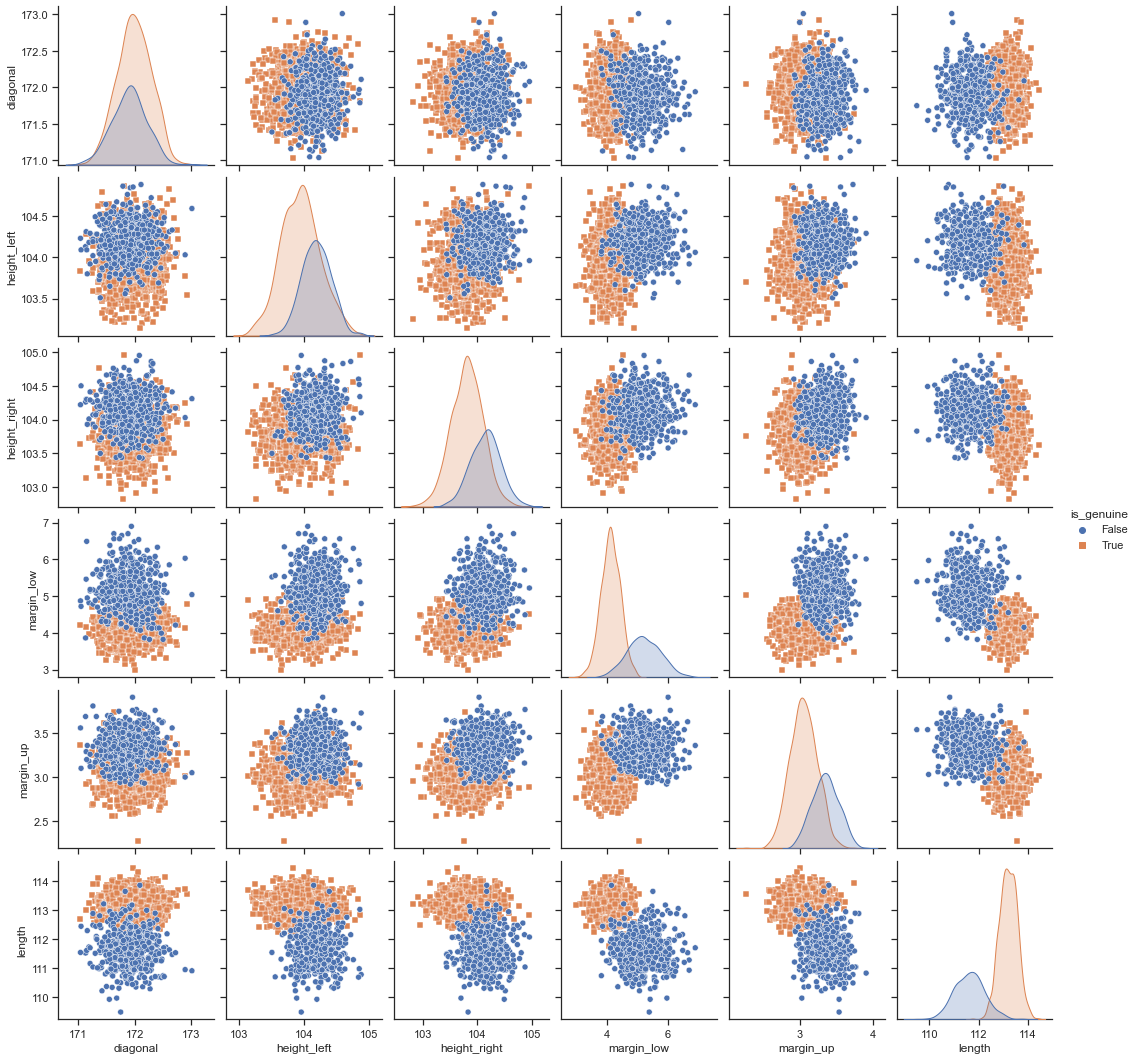

In [5]:
# Tracer le pair plot

sns.set(style="ticks")
sns.pairplot(billet, hue='is_genuine', markers=['o', 's'])

# Afficher le graphique
plt.show()

In [6]:
# Compter le nombre de faux billets et de vrais billets
counts = billet['is_genuine'].value_counts()

# Afficher les résultats
print("Nombre de faux billets :", counts[0])
print("Nombre de vrais billets :", counts[1])

Nombre de faux billets : 500
Nombre de vrais billets : 1000


In [7]:
# Convertir la variable booléenne en 0 et 1
billet['is_genuine'] = billet['is_genuine'].astype(int)

# Afficher le DataFrame mis à jour
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [8]:
# Vérifier les informations sur les données

billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int32  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int32(1)
memory usage: 76.3 KB


In [9]:
# Afficher les valeurs manquantes:
missing_values = billet[billet['margin_low'].isnull()]

# Nombre de valeurs manquantes
nombre_valeurs_manquantes = len(missing_values)

# Pourcentage de valeurs manquantes
pourcentage_valeurs_manquantes = round((nombre_valeurs_manquantes / len(billet)) * 100, 2)

print("Nombre de valeurs manquantes : ", nombre_valeurs_manquantes)
print("Pourcentage de valeurs manquantes : ", pourcentage_valeurs_manquantes, "%.")

missing_values

Nombre de valeurs manquantes :  37
Pourcentage de valeurs manquantes :  2.47 %.


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,NaN,3.25,112.79
99,1,171.93,104.07,104.18,NaN,3.14,113.08
151,1,172.07,103.80,104.38,NaN,3.02,112.93
197,1,171.45,103.66,103.80,NaN,3.62,113.27
241,1,171.83,104.14,104.06,NaN,3.02,112.36
251,1,171.80,103.26,102.82,NaN,2.95,113.22
284,1,171.92,103.83,103.76,NaN,3.23,113.29
334,1,171.85,103.70,103.96,NaN,3.00,113.36
410,1,172.56,103.72,103.51,NaN,3.12,112.95
413,1,172.30,103.66,103.50,NaN,3.16,112.95


 > Plusieurs approches peuvent être utilisées pour **traiter les valeurs manquantes** dans la variable cible :
>- **Suppression des lignes** : cela peut entraîner une **perte d'informations** si les lignes supprimées contiennent également des informations utiles pour les autres variables indépendantes.
>- **Imputation statistique** : cela peut introduire une distorsion si les **valeurs manquantes ne sont pas aléatoires** et sont liées à d'autres variables.
>- **Modélisation prédictive** : construire un **modèle séparé pour prédire les valeurs manquantes** dans la variable cible en fonction des autres variables indépendantes peut fournir des **estimations plus précises**.

Nous choisissons donc d'utiliser la modélisation prédictive de la **Régression Linéaire Multiple**.

- ###  Application de la Régression linéaire

In [10]:
# Sélection des données complètes
billet_complet = billet.dropna(subset=['margin_low'])

# Séparation des variables indépendantes et variable cible pour les données complètes
X = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']
y = 'margin_low'

# Utilisation de la fonction backward
significant_indices = backward(billet_complet, X, y)
print("Paramètres significatifs Retenus:", significant_indices)

Paramètres significatifs Retenus: ['is_genuine', 'margin_up']



Vérification des hypothèses de la Régression Linéaire:

1. Vérification de la linéarité :


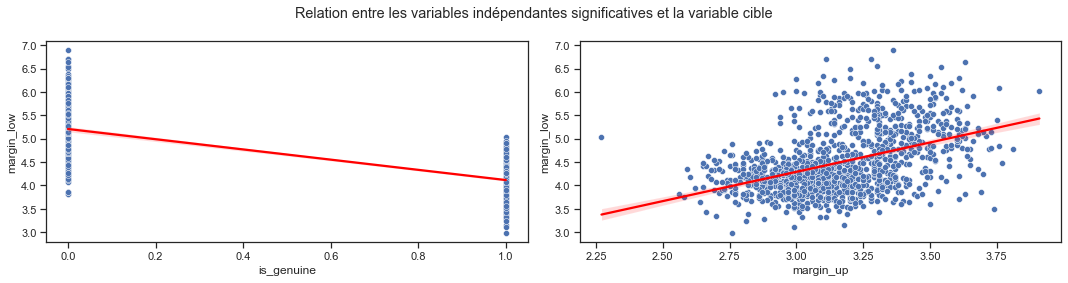

Résultats du test de linéarité : (1.018678695021674, 0.4116327223732603)

L'hypothèse de linéarité est satisfaite. Cela signifie que la relation entre les variables indépendantes et la variable 
dépendante peut être modélisée par une relation linéaire.

2. Détection de la colinéarité (Facteur d'inflation de la variance - VIF) :

Vérification de la Colinéarité des variables indépendantes.
     Features       VIF
0  is_genuine  1.640983
1   margin_up  1.640983

Aucune colinéarité détectée. Les variables indépendantes ne présentent pas de corrélation parfaite entre elles.

3. Vérification de l'homoscédasticité :
Résultats du test d'homoscédasticité : (412.9152172281224, 8.502839200796242e-92, 318.5145076861013, 3.979739995798108e-111)
L'hypothèse d'homoscédasticité n'est pas satisfaite. Cela signifie que la variance des résidus n'est pas constante et peut être influencée par les valeurs prédites.

4. Vérification de la normalité des résidus :


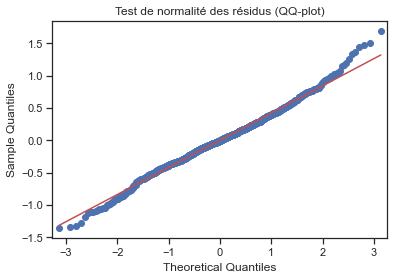

Résultats du test de Jarque-Bera : (31.405887808391185, 1.514600558986168e-07, 0.09725111053481403, 3.7787119015773984)
Les résidus ne suivent pas une distribution normale. 
L'hypothèse de normalité des résidus n'est pas satisfaite.

5. Vérification de l'indépendance des résidus :
Résultats du test de Durbin-Watson : 2.0234089704420195
L'indépendance des résidus est satisfaisante.


Résumé du modèle :
                             OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     886.1
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          8.27e-235
Time:                        14:21:39   Log-Likelihood:                -646.19
No. Observations:                1170   AIC:                             1298.
Df Residuals:                    1167   B

In [11]:
# Sélection des données complètes
billet_complet = billet.dropna(subset=['margin_low'])

# Séparation des variables indépendantes et variable cible pour les données complètes
X = ['is_genuine', 'margin_up']
y = 'margin_low'

# Application de la fonction reg_lin
results = reg_lin(billet_complet, X, y)

# Afficher les résultats
print("\nRésumé du modèle :\n", results['summary'])
print("\nR² des données de test :", results['R2_test'])

### Observations et recommandations

>- Les **variables significatives** pour prédire la variable dépendante sont **"is_genuine"** et **"margin_up"**. 

>- Le modèle ne **satisfait pas pleinement certaines hypothèses** importantes, telles que **l'homoscédasticité et la normalité des résidus**. Des ajustements et des investigations supplémentaires sont nécessaires pour une interprétation plus précise et une meilleure adéquation aux hypothèses de la régression linéaire.

>- Le modèle de régression linéaire présente un **R²** de **0.603**, ce qui signifie que **60.3%** de la variance de la variable dépendante est **expliquée par les variables indépendantes**. 

>- Pour les variables de test, le **R²** est de **0.673**, ce qui indique que le modèle généralise bien et est capable de fournir des prédictions précises sur de nouvelles données.


L'écart entre le **R²** des variables d'entraînement **(0.603)** et le **R²** des variables de test **(0.6736)** peut être expliqué par plusieurs facteurs :

>- **Sous-ajustement (underfitting)**: Le modèle n'est **pas assez complexe pour capturer la relation sous-jacente des données** et ne parvient pas à bien s'adapter aux données d'entraînement. Il ne capture pas pleinement la relation entre les variables indépendantes et la variable cible.

>- **Biais de l'échantillonnage** : Les différences systématiques entre les données d'entraînement et les données de test peuvent influencer la performance du modèle, conduisant à un écart des R².

>- **Taille de l'échantillon** : L'écart des valeurs de R² peut être dû à des ensembles d'entraînement et de test de tailles différentes. **Des ensembles plus petits peuvent donner des estimations moins précises**, ce qui peut affecter la performance du modèle.

Voici quelques propositions et pistes d'améliorations à explorer pour le modèle de régression linéaire :
> 1. Explorer des modèles plus complexes : **Utiliser des modèles non linéaires telles que la régression polynomiale**, les splines ou les modèles d'arbres de décision ou des techniques d'apprentissage automatique avancées pour mieux capturer la relation entre les variables.

> 2. Ajouter de nouvelles variables : **Identifier et inclure des variables supplémentaires** qui pourraient être pertinentes pour améliorer la prédiction.

> 3. Collecter plus de données : **Augmenter la taille et la diversité de l'ensemble de données** pour une meilleure précision du modèle.

> 4. Utiliser des techniques de régularisation : Utiliser des **techniques telles que la validation croisée et la régularisation LASSO** pour sélectionner les meilleures variables et optimiser les paramètres du modèle, ce qui peut améliorer sa performance prédictive.

En implémentant ces améliorations, il est possible d'augmenter la capacité de généralisation et d'améliorer les performances de prédiction du modèle.

In [12]:
# Remplacement des valeurs manquantes de la variable cible
# Création du modèle de régression linéaire et ajustement aux données complètes
model = LinearRegression()
model.fit(billet_complet[X], billet_complet[y])

# Remplacement des valeurs manquantes par les valeurs prédites
billet['margin_low'] = billet.apply(lambda row: model.predict([row[X]])[0] if pd.isnull(row['margin_low']) else row['margin_low'], axis=1)

# Afficher les statistiques descriptives après le remplacement
print("\nStatistiques descriptives après le remplacement :")
print(billet['margin_low'].describe())


Statistiques descriptives après le remplacement :
count    1500.000000
mean        4.482863
std         0.659849
min         2.980000
25%         4.027500
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64


## Partie 2: Modélisations statistiques

### <a id="B1">1. Modélisation avec régression logistique</a>

In [13]:
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


Optimization terminated successfully.
         Current function value: 0.028458
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                  0.9549
Time:                        14:21:41   Log-Likelihood:                -34.149
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                4.162e-309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -93.5468    263.799     -0.355      0.723    -610.584     423.490
diagonal        -0.288

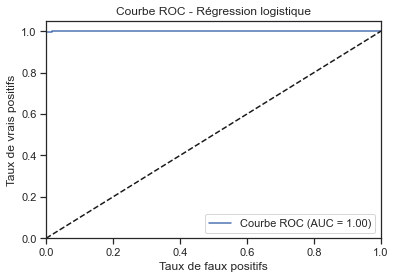

In [14]:
# Séparation des variables indépendantes et variable cible
X = billet.drop('is_genuine', axis=1)
y = 'is_genuine'

# Appliquer la régression logistique
reg_log_results = reg_log(billet, X.columns, y)

### Conclusions:

> 1. **Le modèle de régression logistique présente des performances très élevées** dans la détection de l'authenticité des billets. Les métriques de classification telles que la **précision, le rappel et le F1-score sont toutes à 0.99** pour les deux classes (faux billets et billets authentiques).

> 2. **La matrice de confusion confirme les bonnes performances du modèle**, avec seulement 2 faux positifs et 1 faux négatif sur un échantillon de test de 300  de billets.

> 3. **L'exactitude globale du modèle est de 0.99**, ce qui indique que le modèle fait des **prédictions très précises** dans l'ensemble.

> 4. Les variables **height_right, margin_low, margin_up et length sont significatives** dans le modèle de régression logistique. Cela signifie que ces variables ont un **impact significatif sur la prédiction de l'authenticité des billets**.

> 5. Le modèle de régression logistique a de bonnes performances avec un **R-carré de 0.95**, ce qui indique qu'il **explique une grande partie de la variance des données**.

>En résumé, **le modèle de régression logistique est capable de détecter avec précision l'authenticité des billets**, avec des performances élevées et des métriques de classification excellentes. Les variables significatives dans le modèle fournissent des informations sur les caractéristiques des billets qui influencent leur authenticité.

In [23]:
# Charger les données
billet_test= pd.read_csv('billets_test.csv')
billet_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [24]:
# Préparation des nouvelles données
billet_test = billet_test.drop('id', axis=1)
X_train=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']
y_train='is_genuine'

# Prédiction sur les nouvelles données
predict_billets(billet, X_train,y_train, billet_test)

Optimization terminated successfully.
         Current function value: 0.028458
         Iterations 13


,diagonal,height_left,height_right,margin_low,margin_up,length,Resultat
0,172.09,103.95,103.73,4.39,3.09,113.19,Vrai
1,171.52,104.17,104.03,5.27,3.16,111.82,Faux
2,171.78,103.80,103.75,3.81,3.24,113.39,Vrai
3,172.02,104.08,103.99,5.57,3.30,111.10,Faux
4,171.79,104.34,104.37,5.00,3.07,111.87,Faux


### <a id="B2">2. Modélisation avec k-means</a>



Matrice de confusion:
[[481  19]
 [  2 998]]

Métriques de classification:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       500
           1       0.98      1.00      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500



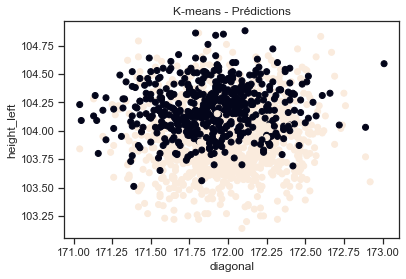

In [15]:
# Séparation des variables indépendantes et variable cible
X = billet.drop('is_genuine', axis=1)
y = 'is_genuine'

# Appliquer la regression avec k-means
kmeans_results = reg_kmeans(billet, X.columns, y)

### Conclusions:

> 1. La matrice de confusion: Le modèle a correctement prédit **481 faux** billets et **998 vrais** billets. Il y a eu **19 faux positifs** (prédits comme vrai alors qu'ils sont faux) et **2 faux négatifs** (prédits comme faux alors qu'ils sont vrais).

> 2. Métriques de classification : Le modèle a atteint une **précision de 1.00 pour la classe 0 (faux billets)** et une **précision de 0.98 pour la classe 1 (vrais billets)**. Le rappel **(recall) est de 0.96 pour la classe 0** et de **1.00 pour la classe 1**. Le F1-score, qui est une mesure harmonique combinant précision et rappel, est de **0.98 pour la classe 0** et de **0.99 pour la classe 1**. L'exactitude (accuracy) globale du modèle est de **0.99**, ce qui signifie qu'il a **correctement prédit 99% des échantillons**.

>En résumé, le modèle K-means a obtenu de très bons résultats pour la détection des vrais et faux billets, avec une précision élevée et un rappel élevé pour les deux classes. **Cela suggère que le modèle est capable de distinguer efficacement les caractéristiques des vrais billets des faux billets**.

 ### <a id="B3">3. Comparaison des performances des deux modèles (régression logistique et K-means)</a>

In [16]:
# Affichage des matrices de confusion
print("Matrice de confusion - Régression logistique:")
print(reg_log_results['confusion_matrix'])

print("\nMatrice de confusion - K-means:")
print(kmeans_results['confusion_matrix'])

# Affichage des métriques de classification
print("\nMétriques de classification - Régression logistique:")
print(reg_log_results['classification_report'])

print("\nMétriques de classification - K-means:")
print(kmeans_results['classification_report'])

Matrice de confusion - Régression logistique:
[[108   2]
 [  1 189]]

Matrice de confusion - K-means:
[[481  19]
 [  2 998]]

Métriques de classification - Régression logistique:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       110
           1       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


Métriques de classification - K-means:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       500
           1       0.98      1.00      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500



 En examinant les résultats des deux modèles, voici les conclusions pertinentes :

 1. Matrice de confusion :

>- **Régression logistique** : Le modèle a eu 2 faux positifs (billets authentiques classés comme contrefait) et 1 faux négatif (billet contrefait classé comme authentique). Ce qui correspond à une **erreur** de classification de **1.67%**  pour les **billets authentiques** et **0.53%** pour les **billets contrefaits**.

>- **K-means** : Le modèle a eu 19 faux positifs et 2 faux négatifs. Ce qui correspond à une **erreur** de classification de **3.8%** pour les **billets authentiques** et de **0.2%** pour les **billets contrefaits**.

 2. Métriques de classification :

>- **Régression logistique** : Le modèle a une précision, un rappel et un f1-score de **0,99** pour la **classe des billets authentiques**, ce qui indique une **performance élevée dans la détection des vrais billets**.

>- **K-means** : Le modèle affiche également une précision, un rappel et un f1-score élevés de **0,98 à 1,00 pour la classe des billets authentiques**.

 **En conclusion**, les deux modèles ont des performances similaires dans la détection des faux billets, avec des résultats cohérents dans les matrices de confusion et les métriques de classification. Cependant, Il convient également de noter que **le modèle de régression logistique présente des erreurs de classification légèrement inférieures pour les deux classes de billets**.

### <a id="B4">4. Recommandations basées sur les résultats obtenus</a>

En tant que data analyst ayant réalisé ce projet pour l'Organisation Nationale de lutte Contre le Faux-Monnayage (ONCFM) visant à mettre en place un algorithme de détection automatique de faux billets, je vous présente les recommandations suivantes basées sur les résultats obtenus :

>1. **Choix du Modèle** : Je recommande l'utilisation du **Modèle de Régression Logistique pour la détection automatique des faux billets**. Car ce modèle a démontré globalement des **performances supérieures** à celui de K-Means, avec des **pourcentages d'erreur plus faibles** pour la détection des faux billets. 

>2. **Importance du Rappel** : Étant donné que notre objectif principal est de détecter un maximum de faux billets, **il est essentiel de prendre en compte le rappel (recall)** dans les métriques de classification. Le modèle de régression logistique a affiché un **rappel plus élevé** pour la classe des **billets contrefaits** (**98%**) par rapport à K-MEANS(**96%**).

>3. **Précision pour les vrais billets** : La régression logistique a démontré une **précision plus élevée** pour la classe des billets authentiques (**99%**) par rapport à K-MEANS (**98%**). Cela suggère que ce **modèle est plus susceptible de classer correctement les vrais billets**, minimisant ainsi les faux positifs et évitant des inconvénients aux détenteurs de billets authentiques.

>4. **Facilité d'implémentation** : Lors du choix du modèle, il est important de prendre en compte la facilité d'implémentation et la complexité du modèle. La **Régression logistique est relativement simple à mettre en œuvre et à interpréter**, ce qui peut être un avantage dans le contexte de lutte contre les faux billets. Cependant, Si l'organisation dispose d'un grand ensemble de données et souhaite une approche non supervisée, explorer l'utilisation de K-means comme modèle complémentaire pour la détection des faux billets.

>5. **Évaluation approfondie** : Je recommande d'effectuer une évaluation plus approfondie des modèles en utilisant des techniques de **validation croisée spécifiquement adaptées au contexte de lutte contre les faux billets**. Cela permettra d'obtenir des **performances cohérentes et robustes du modèle choisi**, en tenant compte des particularités des données de faux billets.

>6. **Combinaison des modèles** : Une autre approche à considérer est **la combinaison des résultats** des deux modèles. Il est possible d'utiliser la régression logistique comme modèle principal et K-means comme modèle complémentaire pour détecter les cas ambigus ou atypiques, améliorant ainsi la robustesse de la prédiction. Cependant, cette combinaison de modèles doit également être évaluée et validée pour assurer sa généralisation et son efficacité.

>7. **Surveillance régulière** : Je recommande de mettre en place une **procédure de surveillance régulière des performances du modèle**. Cela peut inclure l'utilisation de nouveaux ensembles de données ou la réalisation de mises à jour périodiques pour améliorer sa capacité à détecter les faux billets et maintenir sa performance au fil du temps. **L'amélioration continue du modèle est essentielle pour s'adapter aux nouvelles techniques de contrefaçon** et garantir une lutte efficace contre les faux billets.

En résumé, il est **crucial de prendre en compte l'aspect de la généralisation** lors du choix et de l'évaluation des modèles de détection automatique de faux billets. Les recommandations ci-dessus soulignent l'importance de **l'évaluation approfondie**, de la **validation croisée** adaptée au contexte, de la **surveillance régulière et de l'amélioration continue** pour assurer des performances fiables et cohérentes du modèle dans la lutte contre la contrefaçon des billets.